In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
%matplotlib inline

In [2]:
# Constants
RCATH=0.002            # Cathode radius [m]
RTUBE=0.05             # Tube radius [m]
ECOOL=583              # uncorrected cooling energy [eV] from RR symmetrization, set value: 582.98
ECUR=0.01947           # Electron current [A] #!!!!!!!!!!!!!!! zmiana
EXP=33                 # Adiabatic beam expansion factor
MASS_ION= 14896453700  #14896453700   # ion mass [eV/c²] -> oxygen BUT! find better
#MASS_ION_AMU=0.1797    # ion mass [amu] -> neon ??????? 20?
ETA=0.020303           # COOL_LENGTH/CIRC
COOL_LENGTH=1.1        # Cooler interaction zone length [m]; assume error of 1 cm
CIRC=54.178            # Ring orbit [m]; error ca. 12.5 cm assuming the orbit might be 2 cm further out or in
F_REV =253626          # revolution frequency [Hz]

#determine/estimate appropriate error values
RCATH_ERROR=0.0002   #10%
RTUBE_ERROR=0.0001   #1/10 of a mm machining tolerance
ECOOL_ERROR=1.0      #based on RR symmetrization
ECUR_ERROR=0.0002    #10%
EXP_ERROR=0.1        #no idea
ETA_ERROR=0.00023    #see assumptions for COOL_LENGTH and CIRC above
F_REV_ERROR=2500

# Fundamental constants. 
PI=3.14159265358979312
C_LIGHT=299792458              # Speed of light [m/s]
ELEM_CHARGE=1.60217653e-19     # Elementary charge [C]
AMU=931.494102e6               # eV
AMU_KG=1.66053886e-27          # Atomic mass [kg]
MASS_E=510998.950              # Electron mass [eV x c²], CODATA2018
MASS_E_KG=9.1093826e-31        # Electron mass [kg]
BOLTZMANN=8.617343e-5          # [eV/K]
BOLTZMANN_J=BOLTZMANN*ELEM_CHARGE              # [J/K]
ALPHA=7.297352568e-3            # ~1/137
G_E=2.0231930436                # g-Factor electron (CODATA)
EPSILON_0=8.854187817e-12       # C/Vm
MU_0=4.*PI*1e-7                 # permeability of free space, (N*A^2) SI units.
RYDBERG_CONST=13.6056923        # eV
epsilon=1e-15;

# CryringData Class 

Here is a class for Oxygen data analysis 

In [184]:
class CryringData:
    def __init__(self, filename):
        self.name = filename[7:9]    # Extract the substring containing the desired name
        self.prepare_data(filename)
    
    def prepare_data(self, filename):
        myvars = {}
        with open(filename) as myfile:
            for cnt in range(88):
                line = next(myfile)
                if ':' in line:
                    name, var = line.partition(':')[::2]
                    name = name.strip().strip('#')
                    var = var.strip()
                    myvars[name.strip()] = var                
            header_line = next(myfile)
        
        #Values useful for me from header
        self.e_curr = float(myvars['electron current (mA)'])*0.001
        
        try:
            self.main_pow_supply = float(myvars['cath meas voltage (V)'])
        
        except KeyError:
            self.main_pow_supply = float(myvars['cathode voltage (V)']) 
        
        self.cooling_energy = float(myvars['cooling energy (eV)']) #this is not the best chice- it is a set value- better from shotky
        self.ion_energy = float(myvars['ion energy (MeV/u)'])
        #self.header_keys = myvars.keys()
        #self.header_values = myvars.values()
        
        #Labels give the labels for each array in self.data
        header_line = header_line.strip('#')
        header_line = re.split(r'\[\d+\]', header_line)
        self.labels = header_line
        #Data - without last two columns (there is str "-")
        self.data = np.genfromtxt(filename, delimiter=',',usecols=range(0, 41, 1),dtype=float)
        
    
    def Edensity(self, E):
        """
        Calculates electron density for given energy and current
        based on Esthers work, 
        
        Esther: uses Ecalib_lab line 705
        ecalib_lab = ElabtoEsc(Elabnew);
        ecalib_lab_err = ElabtoEsc_err(Elabnew, Elabnew_err);
        Ecoolsc = ElabtoEsc(ECOOL);
        Ecoolsc_err = ElabtoEsc_err(ECOOL, ECOOL_ERROR);

        ecalib_cm = EsctoEcm(ecalib_lab, Ecoolsc);
        ecalib_cm_err = EsctoEcm_err(ecalib_lab, Ecoolsc, ecalib_lab_err, Ecoolsc_err);
        """
        #gamma = 1 + E / MASS_E
        #beta = np.sqrt(1.0-pow(gamma,-2))
        beta_e = np.sqrt(1.0-pow(1+E/MASS_E,-2))
        dens = self.e_curr / (ELEM_CHARGE * EXP * np.pi * RCATH * RCATH * beta_e * C_LIGHT)
        return dens

    def ElabtoEsc(self, Elab):
        """
        Performs space-charge correction on lab energy values
        Esther
        """
        SC = 0
        Eold, Enew, ne, acc1, acc, eps, factor = 0, 0, 0, 0, 1.0, 0.0000001, 0
        i, maxiter, sign = 0, 100, 0
        factor = ELEM_CHARGE*RCATH*RCATH*EXP/(4*EPSILON_0) * (1 + 2*np.log(RTUBE/(RCATH*np.sqrt(EXP))))
        while np.all(acc > eps) and i < maxiter:
            Eold = Enew
            Enew = Elab - SC
            ne = self.Edensity(Elab)
            SC = ne * factor
            acc1 = Eold / Enew - 1
            sign = np.where(acc1 > 0, 1, -1)
            acc = sign * acc1
            i += 1
        return Enew
    
    def ElabtoEsc_err(self, Elab, Elab_err):
        """
        Performs error calculation for the space-charge correction
        based on Esther code
        
        Problem: here we have the Elab_err as a input from cooler calibration, 
        for me this error for Elab will be HUGE! I use a smoothing function of Arnold output
        """
        #uncertain parameters: RTUBE, RCATH, EXP, ECUR, Elab
        dd = RTUBE / RCATH / math.sqrt(EXP)
        dd_err = 1/RCATH/math.sqrt(EXP)*RTUBE_ERROR + RTUBE/(RCATH*RCATH)/math.sqrt(EXP)*RCATH_ERROR + 0.5*RTUBE/RCATH/math.pow(EXP, 2/3)*EXP_ERROR
        factor = 0.25 * (1.0 + 2.0 * math.log(dd))/(PI * EPSILON_0 * C_LIGHT) * ECUR / MASS_E
        factor_err = 0.25/(PI*EPSILON_0*C_LIGHT*MASS_E) * (ECUR * dd_err + math.log(dd) * ECUR_ERROR)
        Uk = Elab / MASS_E
        Uk_err = Elab_err/MASS_E

        enew = ElabtoEsc(Elab)  # define ElabtoEsc function
        enew_err = Uk_err + factor_err*(enew+1)/math.sqrt(enew*(enew+1))

        Esc_err = enew_err * MASS_E
        return Esc_err

    def EsctoEcm(self, Esc):
        """
        Performs transformation of (space-charge corrected) lab energy to centre-of-mass energy
        Esther
        """
        Ecool = self.cooling_energy#-1.9455 #value was obtained based on the RR peak
        Ei = Ecool * MASS_ION / MASS_E
        sign = np.ones_like(Esc)
        sign[Esc > Ecool] = 1
        sign[Esc <= Ecool] = -1

        aa = MASS_ION + MASS_E
        sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
        sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
        bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte

        Ec = sign * (np.sqrt(aa*aa + 2 * bb) - aa)
        return Ec
    
    
#     def EsctoEcm_err(self, Esc, Esc_err, Ecool_err):
#         """
#         Performs error calcuation for the lab-to-cm transformation
#         """
#         Ecool = self.cooling_energy
#         Ei = Ecool * MASS_ION / MASS_E
#         Ei_err = Ecool_err * MASS_ION / MASS_E #assume no error for MASS_ION and MASS_E
#         aa = MASS_ION + MASS_E #no error
#         sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
#         sqrti_err = Ei_err / np.sqrt(Ei * (Ei + 2 * MASS_ION)) * (Ei + MASS_ION)
#         sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
#         sqrte_err = Esc_err / np.sqrt(Esc * (Esc + 2 * MASS_E)) * (Esc + MASS_E)
#         bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte
#         bb_err = (Ei_err * (Esc + MASS_E) + Esc_err * (Ei + MASS_ION) +
#                   sqrti * sqrte_err + sqrte * sqrti_err)
#         Ec_err = bb_err / np.sqrt(aa * aa + 2 * bb)
#         return Ec_err

    


#     def Edensity_err(I, E, E_err):
#         """
#         Calculate the error for the electron density
#         E_err = ecalib_lab_err see above
#         """
#         I = self.e_curr
#         I_err = ECUR_ERROR
#         gamma = (MASS_E + E) / MASS_E
#         gamma_err = E_err / MASS_E
#         beta = sqrt(1 - (1 / (gamma * gamma)))
#         beta_err = gamma_err / (gamma * gamma * sqrt(gamma * gamma - 1))
#         cc = 1 / (ELEM_CHARGE * EXP * PI * RCATH * RCATH * beta * C_LIGHT)
#         dens_err = cc * (I_err + I * (EXP_ERROR / EXP + beta_err / beta))

#         return dens_err
    
    def calibrated_LAB(self):
        """
        Performs calibration for energy, for oxygen data collection we had a long jump of main power supply 
        and the arnold values are deformated at begining, moreover they are scaterred (needs to be smoothen-> value)
        """
        if self.name == "01":
            value = 100
        elif self.name == "03": 
            value = 200
        elif self.name == "04": 
            value = 500
        elif self.name == "05": 
            value = 200
        elif self.name == "06": 
            value = 650 #usunac ostatnie dwa punkty?
        elif self.name == "07": 
            value = 400            
        elif self.name == "08": 
            value = 300
        elif self.name == "09": 
            value = 8500
        elif self.name == "10": 
            print("SPARK? wird Arnold behaviour")
        elif self.name == "11": 
            value = 1200
        elif self.name == "12": 
            value = 170 #moze trzeba usunac pierwsze kilka punktow???
        elif self.name == "13": 
            value = 250 #usunac ostatnie :1250
        else: value = 1000
            
       
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        x = self.data[:,0]
        y = self.data[:,13] #g35
        spl = UnivariateSpline(x, y, s=value)
        y_fit = spl(x)*slope+intercept

        if self.name=="01":
            return (self.EsctoEcm(self.ElabtoEsc(y_fit)))
        else:
            return np.abs(self.EsctoEcm(self.ElabtoEsc(y_fit))) 

    def smoothen_G35(self):
        """
        To analyse the differences between different ramps in correction of energy (Uset(Arnold))
        """
        if self.name == "01":
            value = 25000
        elif self.name == "03": 
            value = 200
        elif self.name == "04": 
            value = 500
        elif self.name == "05": 
            value = 200
        elif self.name == "06": 
            value = 750 #usunac ostatnie dwa punkty?
        elif self.name == "07": 
            value = 450            
        elif self.name == "08": 
            value = 400
        elif self.name == "09": 
            value = 8500
        elif self.name == "10": 
            print("SPARK? wird Arnold behaviour")
        elif self.name == "11": 
            value = 1200
        elif self.name == "12": 
            value = 500 #moze trzeba usunac pierwsze kilka punktow???
        elif self.name == "13": 
            value = 250 #usunac ostatnie :1250
        else: value = 1000
            
       
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        x = self.data[:,0]
        y = self.data[:,13] #g35
        spl = UnivariateSpline(x, y, s=value)
        y_fit = spl(x)*slope+intercept
        return y_fit
    
    def calibrated_LAB_err(self, value=1000):
        """
        Error here may be from diff between the energy from fit and from set CM energy?
        """
        pass

    def histogram(self, s=1000):
        hist=[[],[]]
        x = self.calibrated_LAB(s)
        y = self.data[:,7][::-1]
        min_x = np.min(np.abs(x))
        max_x = np.max(np.abs(x))
        range_x = np.abs(max_x-min_x)
        bins_x = np.ceil(range_x/0.1).astype(int)
        print(bins_x)
        hist[1] = np.histogram(x, bins=abs(bins_x), range=(min_x,min_x+(bins_x*0.1)), weights=y)[0]
        hist[0] = np.arange(min_x, min_x+(abs(bins_x)*0.1), 0.1)
        return hist
    
    def compose_data_v1(self, other, s1=1000, s2=1000, b=0.1):
        hist=[[],[]]
        x = np.concatenate((self.calibrated_LAB(s1), other.calibrated_LAB(s2)))
        y = np.concatenate((self.data[:,7], other.data[:,7]))
        print(len(y),len(x))
        min_x = np.min(np.abs(x))
        max_x = np.max(np.abs(x))
        range_x = np.abs(max_x-min_x)
        bins_x = np.floor(range_x/b).astype(int)
        hist[1] = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*b)), weights=y)[0]
        hist[0] = np.arange(min_x, min_x+(bins_x*b), b)
        return hist
    
    ## histogram and analyse the background

    #add histograms
    
    #np.histogram





## Upload all data 

In [185]:
filename = "hydrocal_par5p_oxygen.dat"
theory = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)


In [186]:
data01 = CryringData('06ramp001.yrdr')
data03 = CryringData('06ramp003.yrdr')
data04 = CryringData('06ramp004.yrdr')
data05 = CryringData('06ramp005.yrdr')
data06 = CryringData('06ramp006.yrdr')
data08 = CryringData('06ramp008.yrdr')
data07 = CryringData('06ramp007.yrdr')
data09 = CryringData('06ramp009.yrdr')
data10 = CryringData('06ramp010.yrdr')
data11 = CryringData('06ramp011.yrdr')
data12 = CryringData('06ramp012-Copy_part1.yrdr')
data22 = CryringData('06ramp012-Copy_part2.yrdr')
data13 = CryringData('06ramp013-Copy1.yrdr')


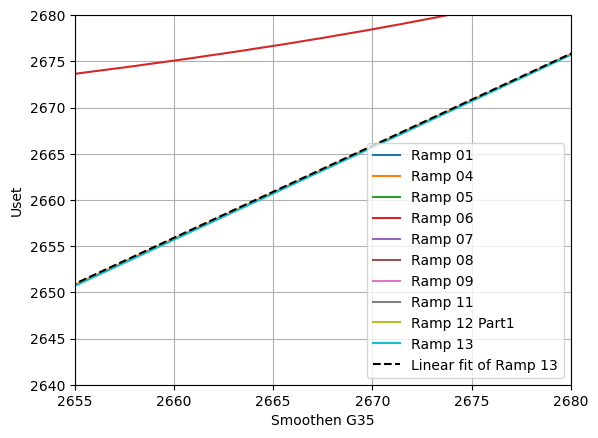

In [214]:
fig = plt.figure()
ax1 = fig.gca()
ax1.plot(data01.smoothen_G35()+14, data01.data[:,1], label = "Ramp "+"01")
# ax1.plot(data03.smoothen_G35()+1, data03.data[:,1], label = "Ramp "+"03")#+1
ax1.plot(data04.smoothen_G35()+1, data04.data[:,1], label = "Ramp "+"04")
ax1.plot(data05.smoothen_G35(), data05.data[:,1], label = "Ramp "+"05")
ax1.plot(data06.smoothen_G35(), data06.data[:,1], label = "Ramp "+"06")
ax1.plot(data07.smoothen_G35()-1.9, data07.data[:,1], label = "Ramp "+"07")
ax1.plot(data08.smoothen_G35()-0.1, data08.data[:,1], label = "Ramp "+"08")
ax1.plot(data09.smoothen_G35(), data09.data[:,1], label = "Ramp "+"09")
ax1.plot(data11.smoothen_G35(), data11.data[:,1], label = "Ramp "+"11")
ax1.plot(data12.smoothen_G35(), data12.data[:,1], label = "Ramp "+"12 Part1")
# ax1.plot(data22.smoothen_G35(), data22.data[:,1], label = "Ramp "+"12 Part2")
ax1.plot(data13.smoothen_G35(), data13.data[:,1], label = "Ramp "+"13")


# Extract x and y values from data13
x13 = data13.data[300:,0]
y13 = data13.data[300:,13] #g35
spl = UnivariateSpline(x13, y13, s=250)
slope = 0.99974
intercept = -0.048
x = spl(x13)*slope+intercept
y = data13.data[300:,1]

# Fit a straight line to x and y
coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)

# Generate range of x values
x_range = np.linspace(2500, 6000, 1000)

# Calculate corresponding y values using the fitted line
y_range = p(x_range)

# Plot the fitted line
ax1.plot(x_range, y_range, 'k--', label='Linear fit of Ramp 13')


plt.xlabel("Smoothen G35")
plt.ylabel("Uset")
#plt.ylim(2937,2939)
#plt.xlim(2942,2943)
#plt.ylim(2939,2941)
#plt.xlim(2943,2945)
#plt.xlim(2655,2680)
#plt.ylim(2640,2680)
#plt.xlim(2950, 3000)
#plt.xlim(5460, 5560)
#plt.ylim(5430,5600)

ax1.legend()
plt.grid()

I have to move Ramp 3 and Ramp 4 right (correction to G35 smoothen) for about 1 V

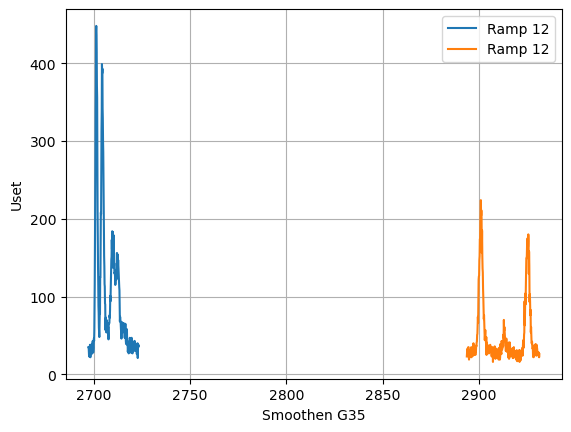

In [123]:
fig = plt.figure()
ax1 = fig.gca()

#ax1.plot(data12.smoothen_G35(), data12.data[:,0], label = "Ramp "+"12")
ax1.plot(data12.data[:,1], data12.data[:,7], label = "Ramp "+"12 Part 1")
ax1.plot(data22.data[:,1], data22.data[:,7], label = "Ramp "+"12 Part 2")
plt.xlabel("Smoothen G35")
plt.ylabel("Uset")
#plt.ylim(292,312)
#plt.xlim(2890,2920)

ax1.legend()
plt.grid()

## Analyse the RR peak position
here change in line 107 in Class to apply correction
### NOW it is without correction

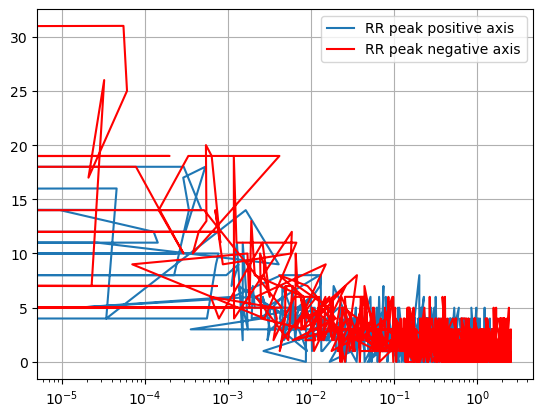

In [7]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data01.calibrated_LAB(), data01.data[:,7], label ="RR peak positive axis")
ax.plot(-data01.calibrated_LAB(), data01.data[:,7],"r-", label = "RR peak negative axis")
ax.set_xscale('log')
plt.grid()
ax.legend()

Text(0.5, 0.9, 'Center: -0.00126249')

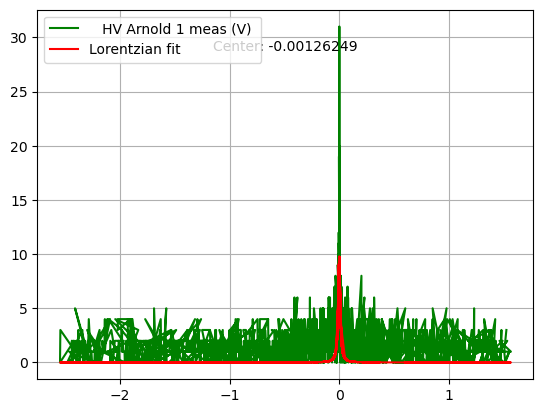

In [8]:
# Define the Lorentzian function
def lorentzian(x, x0, gamma, A):
    return A * (gamma**2) / ((x - x0)**2 + gamma**2)

# Extract the x and y data from your data01 array
x = data01.calibrated_LAB()
y = data01.data[:,7]

# Define the initial parameter values for the fit
x0_init = np.mean(x)
gamma_init = 1.0
A_init = np.max(y)

# Perform the fit using curve_fit
popt, pcov = curve_fit(lorentzian, x, y, p0=[x0_init, gamma_init, A_init])

# Extract the optimal parameter values from the fit
x0_fit, gamma_fit, A_fit = popt

# Plot the original data and the fitted Lorentzian function
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, 'g-', label=data08.labels[13]+str(""))
ax.plot(x, lorentzian(x, x0_fit, gamma_fit, A_fit), 'r-', label='Lorentzian fit')
plt.grid()
ax.legend()
#ax.set_xscale('log')

# Add a text label to show the center position
ax.text(0.5, 0.9, f'Center: {x0_fit:.8f}', ha='center', va='center', transform=ax.transAxes)

### But the correction was obtained for main power supply 5580.5 V. Data collection was done in different main power supply setting

In [9]:
print("Cooling energies for different ramp files \n", 
      "01-", data01.cooling_energy,"\n", "03-", data03.cooling_energy, "\n","04-", data04.cooling_energy,"\n",
     "05-", data05.cooling_energy, "\n", "06-", data06.cooling_energy,"\n", "07-", data07.cooling_energy,"\n",
      "08-", data08.cooling_energy,"\n", "09-", data09.cooling_energy,"\n", "10-", data10.cooling_energy,"\n",
      "11-", data11.cooling_energy,"\n", "12-", data12.cooling_energy, "\n","13-", data13.cooling_energy)

Cooling energies for different ramp files 
 01- 5563.55 
 03- 5563.55 
 04- 5563.55 
 05- 5564.78 
 06- 5564.78 
 07- 5564.78 
 08- 5564.78 
 09- 5564.78 
 10- 5564.78 
 11- 5564.78 
 12- 5564.78 
 13- 5564.78


In [10]:
print("Main power supply \n", 
      "01-", data01.main_pow_supply,"\n", "03-", data03.main_pow_supply, "\n","04-", data04.main_pow_supply,"\n",
     "05-", data05.main_pow_supply, "\n", "06-", data06.main_pow_supply,"\n", "07-", data07.main_pow_supply,"\n",
          "08-", data08.main_pow_supply,"\n", "09-", data09.main_pow_supply,"\n", "10-", data10.main_pow_supply,"\n",
      "11-", data11.main_pow_supply,"\n", "12-", data12.main_pow_supply, "\n","13-", data13.main_pow_supply)

Main power supply 
 01- 5580.5 
 03- 3500.0 
 04- 3500.0 
 05- 3000.0 
 06- 3000.0 
 07- 3000.0 
 08- 3000.0 
 09- 3000.0 
 10- 3000.0 
 11- 3000.0 
 12- 3000.0 
 13- 3000.0


### There is a chance thet we see the unexpected behaviour in comparison of Uset and Arnold

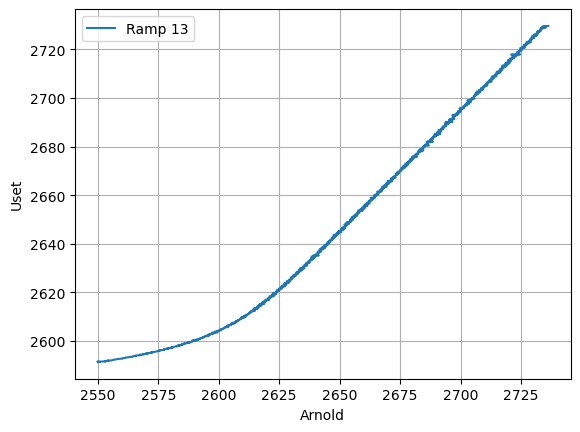

In [11]:
fig = plt.figure()
ax1 = fig.gca()
#ax1.plot(data03.data[:,13], data03.data[:,0], label = "Ramp "+"03")
#ax1.plot(data04.data[:,13], data04.data[:,1], label = "Ramp "+"04")
#ax1.plot(data05.data[:,13], data05.data[:,1], label = "Ramp "+"05")
#ax1.plot(data06.data[:,13], data06.data[:,1], label = "Ramp "+"06")
#ax1.plot(data07.data[:,13], data07.data[:,1], label = "Ramp "+"07")
#ax1.plot(data08.data[:,13], data08.data[:,1], label = "Ramp "+"08")
#ax1.plot(data09.data[:,13], data09.data[:,1], label = "Ramp "+"09")
#ax1.plot(data11.data[:,13], data11.data[:,1], label = "Ramp "+"11")
#ax1.plot(data12.data[:,13], data12.data[:,1], label = "Ramp "+"12")
ax1.plot(data13.data[:,13], data13.data[:,1], label = "Ramp "+"13")

plt.xlabel("Arnold")
plt.ylabel("Uset")
#plt.ylim(1190,1210)
#plt.xlim(2500,3000)
#plt.xlim(2950, 3000)
#plt.xlim(420, 450)

ax1.legend()
plt.grid()
#plt.savefig("compar_without_correction_2.png")

Analyse the soothed G35 values!
## Also by analysing this above  change the files with vertical lines

# Plot all data with obtained energy calibration

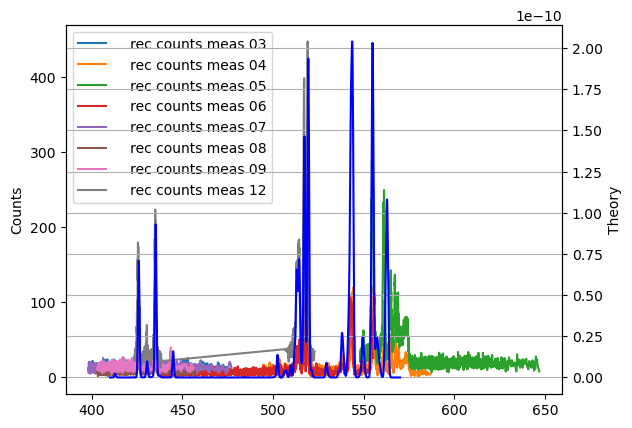

In [12]:
ax1 = plt.subplot()

ax1.plot(data03.calibrated_LAB(), data03.data[:,7], label = data01.labels[7]+"03")
ax1.plot(data04.calibrated_LAB(), data04.data[:,7], label = data01.labels[7]+"04")
ax1.plot(data05.calibrated_LAB(), data05.data[:,7], label = data01.labels[7]+"05")
ax1.plot(data06.calibrated_LAB(), data06.data[:,7], label = data01.labels[7]+"06")
ax1.plot(data07.calibrated_LAB(), data07.data[:,7], label = data01.labels[7]+"07")
ax1.plot(data08.calibrated_LAB(), data08.data[:,7], label = data01.labels[7]+"08")
ax1.plot(data09.calibrated_LAB(), data09.data[:,7], label = data01.labels[7]+"09")
# ax1.plot(data11.calibrated_LAB(), data11.data[:,7], label = data01.labels[7]+"11")
ax1.plot(data12.calibrated_LAB(), data12.data[:,7], label = data01.labels[7]+"12")
# ax1.plot(data13.calibrated_LAB(), data13.data[:,7], label = data01.labels[7]+"13")

ax2 = ax1.twinx()
ax2.plot(theory[:,0], theory[:,1], "b-", label = "FAC calc")


#plt.xlim(0, 14)
plt.xlabel("Calibrated energy")
ax1.set_ylabel('Counts')
ax2.set_ylabel('Theory')

#plt.xlim(540,580)
#plt.xlim(500, 550)
#plt.xlim(420, 450)
ax1.legend()
plt.grid()
#plt.savefig("compar_without_correction_2.png")



## Background analysis

### Ramp 07 and 08 are having the reference step

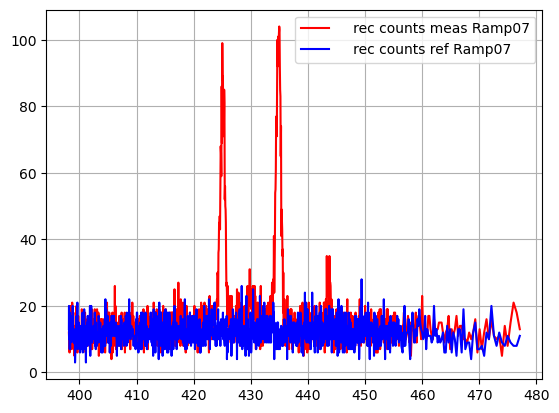

In [13]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data07.calibrated_LAB(), data07.data[:,7], 'r-', label = data01.labels[7]+"Ramp07")
ax.plot(data07.calibrated_LAB(), data07.data[:,9], 'b-', label = data01.labels[9]+"Ramp07")
plt.grid()
ax.legend()

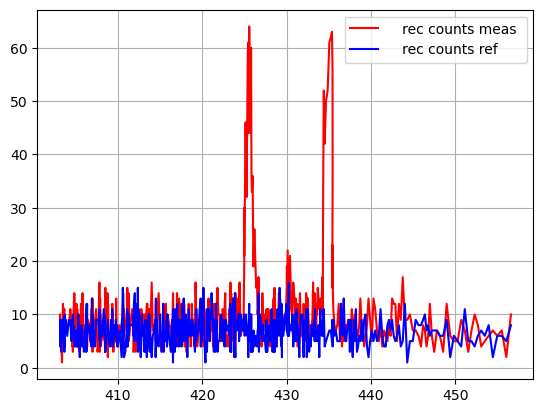

In [14]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'r-', label = data01.labels[7])
ax.plot(data08.calibrated_LAB(), data08.data[:,9], 'b-', label = data01.labels[9])
plt.grid()
ax.legend()

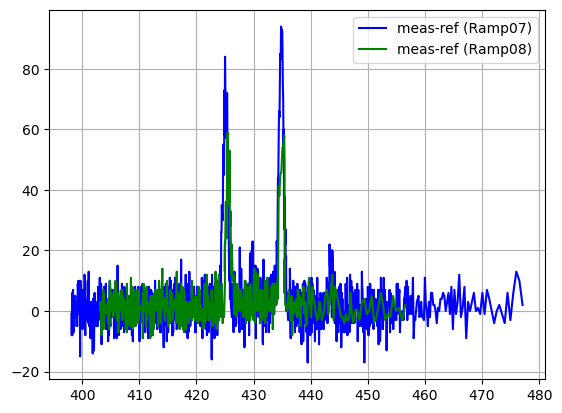

In [15]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data07.calibrated_LAB(), data07.data[:,7]-data07.data[:,9], 'b-', label = "meas-ref (Ramp07)")
ax.plot(data08.calibrated_LAB(), data08.data[:,7]-data08.data[:,9], 'g-', label = "meas-ref (Ramp08)")

plt.grid()
ax.legend()

### For other data

[454 465 655]


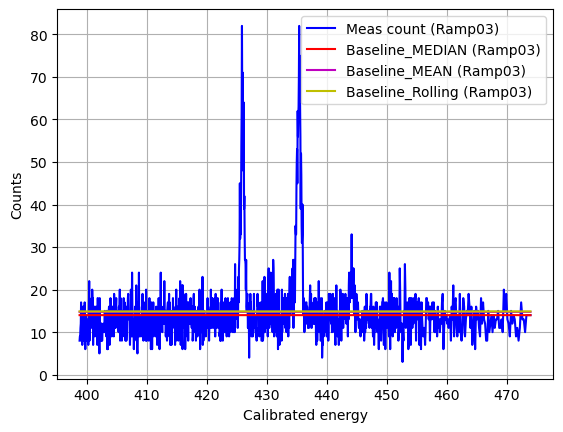

In [16]:
# Generate example data with peaks and background
x = data03.calibrated_LAB()
y = data03.data[:,7]
peaks, _ = find_peaks(y, height=40, distance=10)

print(peaks)
# Exclude peaks from background analysis
mask = np.ones(len(y), dtype=bool)
mask[peaks] = False
background = y[mask]

# Subtract baseline from data
baseline = np.median(background)
y_corrected = y - baseline

baseline2 = np.mean(background)
y_corrected2 = y - baseline2

# Calculate rolling/moving average
window_size = 50 # Set the size of the rolling/moving window
background_rolling = np.convolve(background, np.ones(window_size)/window_size, mode='valid')

# Subtract baseline from data
baseline3 = np.mean(background_rolling)
y_corrected3 = y - baseline3


#Plot
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, 'b-', label = "Meas count (Ramp03)")
ax.plot(x, baseline*np.ones(len(x)), 'r-', label = "Baseline_MEDIAN (Ramp03)")
ax.plot(x, baseline2*np.ones(len(x)), 'm-', label = "Baseline_MEAN (Ramp03)")
ax.plot(x, baseline3*np.ones(len(x)), 'y-', label = "Baseline_Rolling (Ramp03)")
#ax.plot(x, y_corrected, 'g-', label = "Meas - back (Ramp03)")
#plt.ylim(12,16)
plt.xlabel("Calibrated energy")
plt.ylabel("Counts")
plt.grid()
ax.legend()

Median: You can use the median value of the background to subtract it from your data. This can be useful if your data has a lot of outliers or if there are large fluctuations in the background values.

[454 465 655]


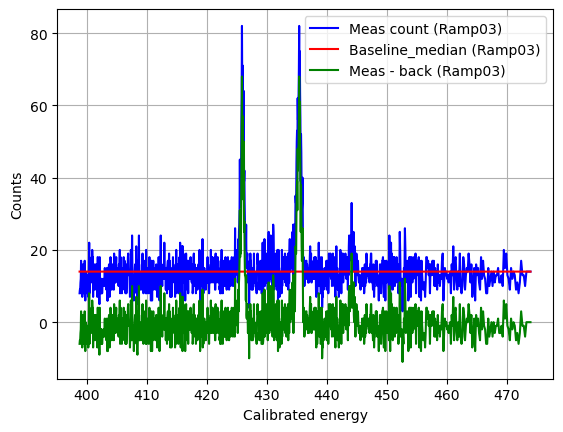

In [17]:
# Generate example data with peaks and background
x = data03.calibrated_LAB()
y = data03.data[:,7]
peaks, _ = find_peaks(y, height=40, distance=10)

print(peaks)
# Exclude peaks from background analysis
mask = np.ones(len(y), dtype=bool)
mask[peaks] = False
background = y[mask]

# Subtract baseline from data
baseline = np.median(background)
y_corrected = y - baseline


#Plot
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, 'b-', label = "Meas count (Ramp03)")
ax.plot(x, baseline*np.ones(len(x)), 'r-', label = "Baseline_median (Ramp03)")
ax.plot(x, y_corrected, 'g-', label = "Meas - back (Ramp03)")
#plt.ylim(14,16)
plt.xlabel("Calibrated energy")
plt.ylabel("Counts")
plt.grid()
ax.legend()

### check at Ramp 07

[463 480 655 665]


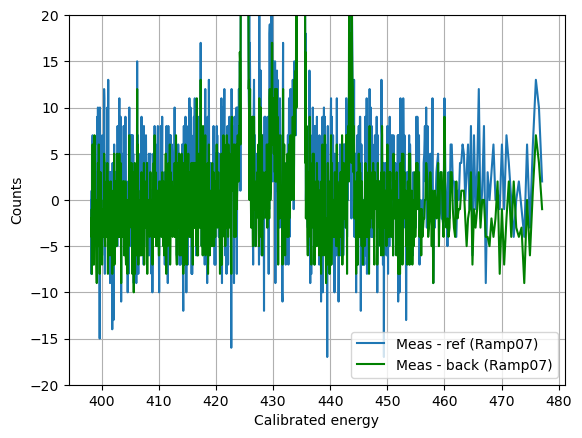

In [18]:
# Generate example data with peaks and background
x = data07.calibrated_LAB()
y = data07.data[:,7]
peaks, _ = find_peaks(y, height=40, distance=10)

print(peaks)
# Exclude peaks from background analysis
mask = np.ones(len(y), dtype=bool)
mask[peaks] = False
background = y[mask]

# Subtract baseline from data
baseline = np.median(background)
y_corrected = y - baseline


#Plot
fig = plt.figure()
ax = fig.gca()
#ax.plot(x, y, 'b-', label = "Meas count (Ramp07)")
#ax.plot(x, data07.data[:,9], 'g-', label = "Meas - back (Ramp07)")
#ax.plot(x, baseline*np.ones(len(x)), 'r-', label = "Baseline_median (Ramp07)")
ax.plot(x, data07.data[:,7]-data07.data[:,9], '-', label = "Meas - ref (Ramp07)")
ax.plot(x, y_corrected, 'g-', label = "Meas - back (Ramp07)")

plt.xlabel("Calibrated energy")
plt.ylabel("Counts")
plt.ylim(-20,20)
plt.grid()
ax.legend()

It is possible that when we had a jump of main power supply the electron beam has moved slightly and it is not completly caught by the collector, then this lost beam is hiting the wall and the residual gasses are increased that is why we have more counts in measurment step (in compare to reference step, although both are after big jump... may be beam is still moving)

### Conclusion:
We will stay with backgroung subtraction based on the median

# Ion current 

# I would like to glue data

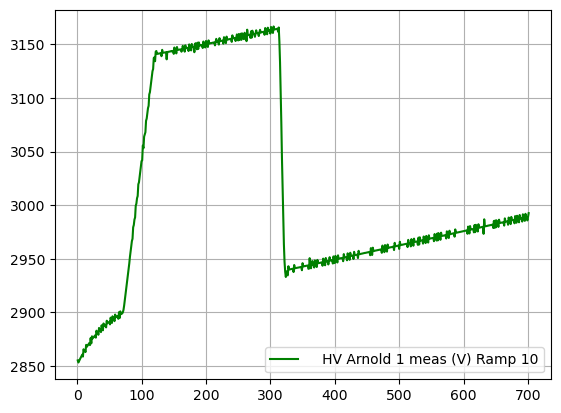

In [19]:
fig = plt.figure()
ax = fig.gca()
#ax.plot(-data08.data[:,3], data08.data[:,7], 'b-', label = data08.labels[7])
#ax.plot(data10.calibrated_LAB(1000), data10.data[:,7], 'b-', label = data08.labels[7]+str("10-calib"))
ax.plot(data10.data[:,0], data10.data[:,13],'g-', label = data08.labels[13]+str("Ramp 10"))
#ax.plot(data09.compose_data_v1(data08,1000,10000,.1)[:,0], data09.compose_data_v1(data08,1000,10000,.1)[:,1], 'r-', label = "SUM")
#plt.xlim(0,5)
#plt.ylim(2700,2900)
#ax.plot(np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000))), np.concatenate((data08.data[:,7], data09.data[:,7])) , 'r-', label = "SUM")

plt.grid()
ax.legend()

In [20]:
data08.histogram()

TypeError: calibrated_LAB() takes 1 positional argument but 2 were given

In [ ]:
#data08.compose_data_v1(data09)

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'b.', label = data08.labels[7])
ax.plot(data09.calibrated_LAB(10000), data09.data[:,7],'g.', label = data08.labels[7])
#ax.plot(data09.compose_data(data08)[:,0], data09.compose_data(data08)[:,1], )
plt.step(data08.compose_data_v1(data09,1000,10000,.1)[0],data08.compose_data_v1(data09,1000,10000,0.1)[1], 'r-', label = "   SUM")
plt.step(data08.compose_data_v1(data09,1000,10000,.2)[0],data08.compose_data_v1(data09,1000,10000,0.2)[1], 'm-', label = "   SUM")
#plt.xlim(440,450)
plt.grid()
ax.legend()

In [ ]:
#data09.compose_data(data08)
x = np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB()))
y = np.concatenate((data08.data[:,7], data09.data[:,7]))
min_x = 405
max_x = 440
range_x = 35#np.abs(max_x-min_x)
bins_x = 350#np.floor(range_x/0.1)
hist = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*0.1)))[0]
e_axis = np.arange(min_x, min_x+(bins_x*0.1), 0.1)
#plt.step(e_axis, hist)

In [ ]:
x = data08.calibrated_LAB()
y = data08.data[:,7]
min_x = 405
max_x = 440
range_x = 35#np.abs(max_x-min_x)
bins_x = 350#np.floor(range_x/0.1)
hist = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*0.1)), weights=y[::-1])[0]
e_axis = np.arange(min_x, min_x+(bins_x*0.1), 0.1)
plt.step(e_axis, hist)


In [ ]:
data06 = CryringData('06ramp006.yrdr')
data06.data

In [ ]:
calib06 = data06.calibrated_LAB()
calib06

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(calib06, data06.data[:,7], label = data06.labels[7])
plt.grid()
ax.legend()

# RR correction + RR background

In [ ]:
# fig = plt.figure()
# ax = fig.gca()
# #ax.plot(data01.calibrated_LAB(5000), data01.data[:,7], 'r-', label = data01.labels[7])
# ax.plot(data01.data[:,1], data01.data[:,7], label = "set CM energy")
# ax.plot((data01.data[:,1]).ElabtoEsc(), data01.data[:,7], label = "set CM energy")
# plt.grid()
# plt.xscale('log')
# ax.legend()

## 1. Is there an overlap in lab energy axis? >NO

In [ ]:
calib07 = data07.calibrated_LAB()
calib08 = data08.calibrated_LAB()
calib09 = data09.calibrated_LAB()
calib11 = data11.calibrated_LAB()
calib11

In [ ]:
calib09-calib08

## 2. write compose function

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'b-', label = data01.labels[7])
ax.plot(data09.calibrated_LAB(10000), data09.data[:,7],'g-', label = data01.labels[7])
#ax.plot(data09.compose_data(data08)[:,0], data09.compose_data(data08)[:,1], 'r-', label = "SUM")

ax.plot(np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000))), np.concatenate((data08.data[:,7], data09.data[:,7])) , 'r-', label = "SUM")

plt.grid()
ax.legend()

In [ ]:

ddd = np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000)))

ddd

In [ ]:
hi,hu = np.histogram(ddd, bins=100)


In [ ]:
plt.plot(hi)

In [ ]:
data07.labels[9]

# Junk

In [ ]:
a = np.array([2,3,3])
b = np.array([4,3,3])

In [ ]:
np.concatenate((a,b))

In [ ]:
np.vstack((a,b))[1]

In [ ]:
np.re


In [ ]:
a=1.3
np.floor(a, dtype=int)


In [ ]:
mean_sim = 400
sigma_sim = 40
data = np.random.normal(loc = mean_sim, scale = sigma_sim, size=10000)
hist = np.histogram(data, bins=350, range=(0,1000))[0]
x = np.arange(400, 455, 0.1)
#plt.step(x, hist)
